# A simple example, solved three ways

This notebook demonstrates a decomposition of a sine wave and a square wave using a very simple, convex SD model. 

In [1]:
%load_ext autoreload
%autoreload 2

In [67]:
from itertools import chain
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from time import time
import seaborn as sns
import scipy.sparse as sp
import cvxpy as cvx
import pickle

In [7]:
import sys
sys.path.append('..')
from osd import Problem
from osd.classes import MeanSquareSmall,  SmoothSecondDifference, SparseFirstDiffConvex, Sparse

In [4]:
rms = lambda x: np.sqrt(np.average(np.power(x, 2)))

## Data generation

In [92]:
np.random.seed(42)
t = np.linspace(0, 1000, 200)
signal1 = np.sin(2 * np.pi * t * 1 / (500.))
signal2 = signal.square(2 * np.pi * t * 1 / (450.))
X_real = np.zeros((3, len(t)), dtype=float)
X_real[0] = 0.15 * np.random.randn(len(signal1))
X_real[1] = signal1
X_real[2] = signal2
y = np.sum(X_real, axis=0)
K, T = X_real.shape

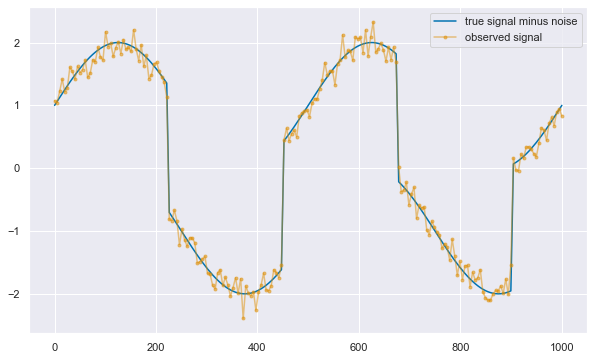

In [93]:
plt.figure(figsize=(10, 6))
plt.plot(t, np.sum(X_real[1:], axis=0), label='true signal minus noise')
plt.plot(t, y, alpha=0.5, marker='.', label='observed signal')
plt.legend()
plt.show()

In [313]:
pattern = {
    'P_x': None,
    'sep_x': 0,
    'P_z': None,
    'sep_z': 0,
    'A': None,
    'B': None
}

In [85]:
T = 20

In [314]:
phi1 = pattern.copy()
phi1['P_x'] = (1/T) * sp.eye(T)
phi1['P_z'] = sp.dok_matrix((0, 0))

In [355]:
phi2 = pattern.copy()
m1 = sp.eye(m=T - 2, n=T, k=0, format='csr')
m2 = sp.eye(m=T - 2, n=T, k=1, format='csr')
m3 = sp.eye(m=T - 2, n=T, k=2, format='csr')
D = m1 - 2 * m2 + m3
phi2['P_x'] = sp.dok_matrix((T, T))
phi2['P_z'] = np.sqrt(1e1/T) * sp.eye(T-2)
phi2['A'] = D

In [377]:
phi3 = pattern.copy()
phi3['sep_z'] = 1
m1 = sp.eye(m=T - 1, n=T, k=0)
m2 = sp.eye(m=T - 1, n=T, k=1)
D = m2 - m1
phi3['A'] = D * (1e0/T)
phi3['P_x'] = sp.dok_matrix((T, T))
phi3['P_z'] = sp.dok_matrix((T-1, T-1))

In [378]:
components = [phi1, phi2, phi3]
quad_terms = chain.from_iterable([(c['P_x'], c['P_z']) for c in components])
P = sp.block_diag(quad_terms)
g = np.array(list(chain.from_iterable(chain.from_iterable([(c['P_x'].shape[0] * [c['sep_x']], 
                                                            c['P_z'].shape[0] * [c['sep_z']]) 
                                                           for c in components]))))
A = sp.bmat(
    [[None, phi2['A'], -sp.eye(T-2), None, None],
     [None, None, None, phi3['A'], -sp.eye(T-1)],
     [sp.eye(T), sp.eye(T), None, sp.eye(T), None]]
)
b = np.zeros(A.shape[0])
b[-T:] = y

In [379]:
canonicalized_problem = {
    'P': P, 'A': A, 'b': b, 'g': g
}

/Users/bennetmeyers/miniconda3/envs/pvi-dev/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


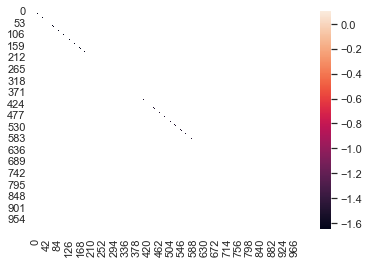

In [380]:
with sns.axes_style('white'):
    sns.heatmap(np.log(P.todense()))

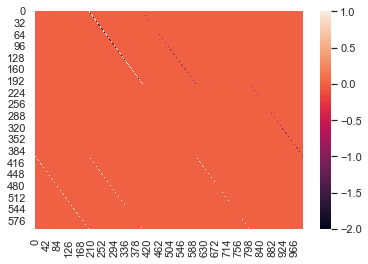

In [381]:
with sns.axes_style('white'):
    sns.heatmap(A.todense())

In [382]:
fp = 'canonicalized_problem.pkl'
with open(fp, 'wb') as file:
    pickle.dump(canonicalized_problem, file)

In [383]:
w = cvx.Variable(len(g))
cost = cvx.quad_form(w, P) + cvx.sum(cvx.abs(w[g==1]))
constraints = [A @ w == b]
problem = cvx.Problem(cvx.Minimize(cost), constraints)

In [384]:
problem.solve(verbose=True)

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Mar 15 03:24:16 PM: Your problem has 997 variables, 1 constraints, and 0 parameters.
(CVXPY) Mar 15 03:24:16 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 15 03:24:16 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 15 03:24:16 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 15 03:24:16 PM: Compiling problem (target solver=OSQP).
(CVXPY) Mar 15 03:24:16 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffin

0.04927871168983031

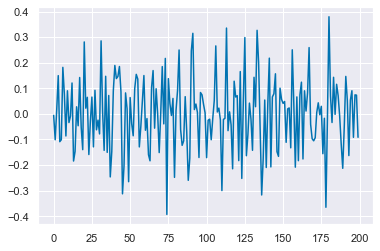

In [385]:
plt.plot(w.value[:T])

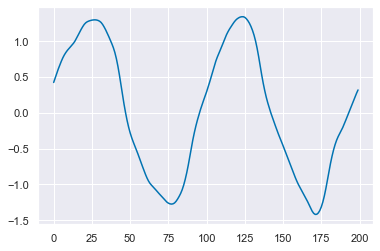

In [386]:
plt.plot(w.value[T:2*T])

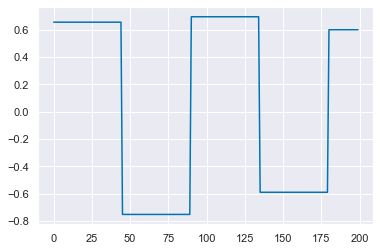

In [387]:
plt.plot(w.value[2*T + T-2: T*2 + T - 2 + T])

In [18]:
b

{'phi_x_q': None,
 'phi_x_s': None,
 'phi_z_q': None,
 'phi_z_s': None,
 'A': None,
 'B': None}